## Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas_ta as ta
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

Get the data

In [2]:
def get_stock_data(tickers, period="1mo", interval="60m"):
    data = {}
    for ticker in tickers:
        try:
            data[ticker] = yf.download(ticker, period=period, interval=interval)['Adj Close']
        except (ValueError, KeyError):
            print(f"Error retrieving data for ticker: {ticker}")
            continue
    
    return pd.DataFrame(data)

tickers = ['AAPL', 'AMZN', "META", "BRK-B"]
num_assets = len(tickers)

stock_data = get_stock_data(tickers, period="1y", interval="1d")

company_names=[]
for t in tickers:
    company_names.append(yf.Ticker(t).info['longName'].replace(", Inc.", "").replace(" Inc.", "").replace(" ", "_"))
stock_data.columns = company_names

stock_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Apple,Amazon.com,Meta_Platforms,Berkshire_Hathaway
Date,,,,
2023-07-05,190.319275,130.380005,293.766327,341.559998
2023-07-06,190.796722,128.360001,291.391205,341.459991
2023-07-07,189.672684,129.779999,289.934204,340.899994
2023-07-10,187.613632,127.129997,293.496887,341.130005
2023-07-11,187.086426,128.779999,297.678314,343.369995


Plot the data

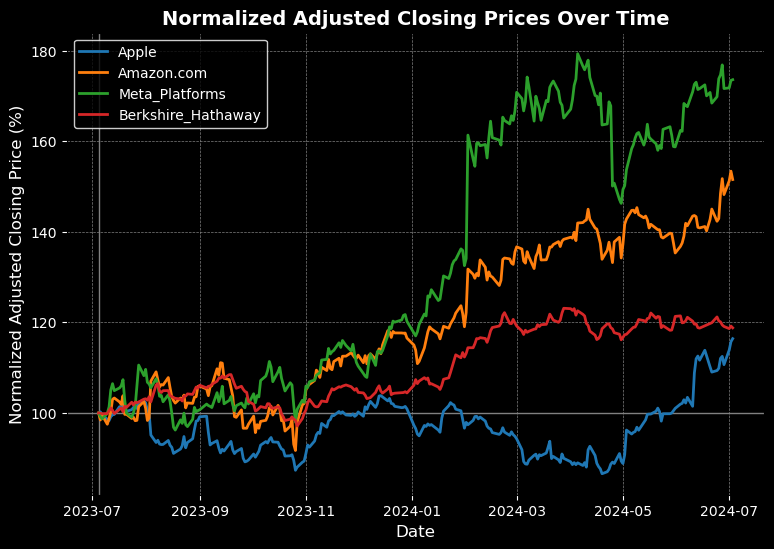

In [3]:
# Normalize the adjusted closing prices to start from 100
norm_adj_close = stock_data / stock_data.iloc[0] * 100

# Create a figure with a black background
fig, ax = plt.subplots(figsize=(9, 6), facecolor='black')
ax.set_facecolor('black')
ax.axhline(100, color='grey', linewidth=1)
ax.axvline(norm_adj_close.index[0], color='grey', linewidth=1)
# Plot the normalized adjusted closing prices
for i, company_name in enumerate(company_names):
    ax.plot(norm_adj_close.index, norm_adj_close[company_name], label=company_name, linewidth=2)

# Set axis labels and title with white color
ax.set_xlabel('Date', fontsize=12, color='white')
ax.set_ylabel('Normalized Adjusted Closing Price (%)', fontsize=12, color='white')
ax.set_title('Normalized Adjusted Closing Prices Over Time', fontsize=14, color='white', fontweight='bold')

# Customize grid and ticks
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', colors='white')

# Add a legend with white font color
ax.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')


# Display the plot
plt.show()

Calculate log return for each security

In [4]:
def calculate_log_return(adj_close):
    return np.log(adj_close).diff().dropna()
    # return np.log(stock_data/stock_data.shift(1)).dropna()

# Calculate the log return for each ticker
log_returns = stock_data.apply(calculate_log_return)

# Calculate the average annual simple rate of return for each ticker
avg_a_logreturns = log_returns.mean() * 252
print(avg_a_logreturns.apply(lambda x: str(round(x, 4)*100) + ' %'))

Apple                 15.260000000000002 %
Amazon.com                         41.74 %
Meta_Platforms                     55.37 %
Berkshire_Hathaway                 17.29 %
dtype: object


Calculate rate of return for each security

In [5]:
def calculate_simple_rate_of_return(adj_close):
    return adj_close.pct_change().iloc[1:]
    # return (adj_close / adj_close.shift(1) - 1).iloc[1:]

# Calculate the simple rate of return for each ticker
simple_returns = stock_data.apply(calculate_simple_rate_of_return)

# Calculate the average annual simple rate of return for each ticker
avg_returns_a = simple_returns.mean() * 252
print(avg_returns_a.apply(lambda x: str(round(x, 4)*100) + ' %'))

Apple                 17.669999999999998 %
Amazon.com                         45.62 %
Meta_Platforms                     61.57 %
Berkshire_Hathaway                 18.02 %
dtype: object


Expected Returns

In [6]:
df = stock_data.resample('Y').last().pct_change()
expected_returns = df.mean()
print(expected_returns.apply(lambda x: str(round(x, 4)*100) + ' %'))

Apple                 15.379999999999999 %
Amazon.com                         30.04 %
Meta_Platforms                     44.37 %
Berkshire_Hathaway                 13.77 %
dtype: object


Calculate standard deviation of each security

In [7]:
std_a = simple_returns.std() * 252 ** 0.5
print(std_a.apply(lambda x: str(round(x, 4)*100) + ' %'))

Apple                              22.07 %
Amazon.com                         27.92 %
Meta_Platforms                     35.66 %
Berkshire_Hathaway    12.030000000000001 %
dtype: object


Calculate the covariance between the securities

In [8]:
cov_matrix_a = simple_returns.cov() * 252
cov_matrix_a
# corr() shouldn't be * by 250

,Apple,Amazon.com,Meta_Platforms,Berkshire_Hathaway
Apple,0.048687,0.016778,0.019413,0.004669
Amazon.com,0.016778,0.077980,0.060069,0.005965
Meta_Platforms,0.019413,0.060069,0.127194,0.009652
Berkshire_Hathaway,0.004669,0.005965,0.009652,0.014461


Mean-Variance Portfolio Optimization

In [9]:
def calculate_portfolio_return(weights, mean_returns):
    """
    Calculate the expected return of a portfolio given the asset weights and mean returns.
    """
    portfolio_return = np.dot(weights, mean_returns)
    return portfolio_return

def calculate_portfolio_volatility(weights, covariance_matrix):
    """
    Calculate the volatility (standard deviation) of a portfolio given the asset weights and covariance matrix.
    """
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_volatility

def portfolio_optimization(mean_returns, covariance_matrix, target_return, num_assets):
    """
    Perform mean-variance portfolio optimization to find the optimal asset weights for a given target return.
    """
    # Define the lower and upper bounds for asset weights
    lower_bound = 0
    upper_bound = 1

    # Set the initial weights to equal values (1/n, where n is the number of assets)
    initial_weights = np.ones(num_assets) / num_assets

    # Define the constraints
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Fully invested portfolio - 'eq' type equality
        {'type': 'eq', 'fun': lambda weights: calculate_portfolio_return(weights, mean_returns) - target_return}  # Target return
    ]

    # Define the bounds for asset weights
    bounds = tuple((lower_bound, upper_bound) for _ in range(num_assets))

    # Perform optimization
    result = minimize(
        fun=calculate_portfolio_volatility,
        x0=initial_weights,
        args=(covariance_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # Get the optimal asset weights
    optimal_weights = result.x

    return optimal_weights

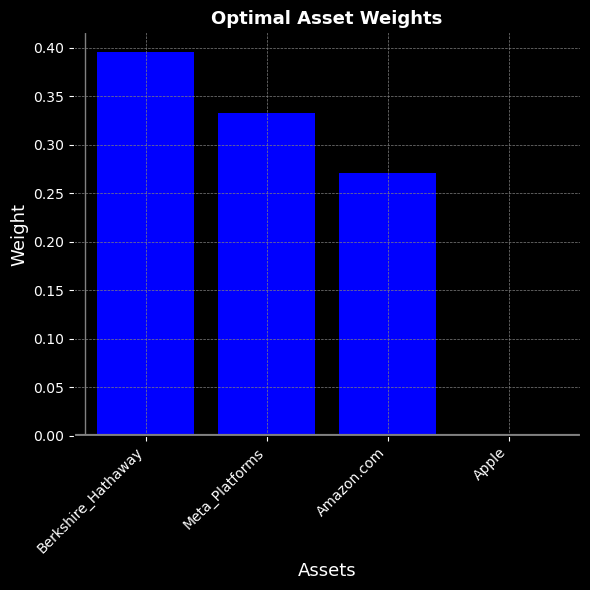

In [10]:
def plot_optimal_weights(optimal_weights, asset_names):
    """
    Plot the optimal asset weights as a bar chart.
    """
    
    # Sort the weights in descending order for better visualization
    sorted_indices = np.argsort(-optimal_weights)
    sorted_weights = optimal_weights[sorted_indices]
    sorted_asset_names = [asset_names[i] for i in sorted_indices]

    # Create a figure with a black background
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
    ax.set_facecolor('black')

    # Plot the bar chart
    ax.bar(range(len(sorted_weights)), sorted_weights, color='blue')
    
    # Set axis labels, title, and ticks with white color
    ax.set_xticks(range(len(sorted_weights)))
    ax.set_xticklabels(sorted_asset_names, rotation=45, ha='right', color='white')
    ax.set_xlabel('Assets', color='white', fontsize=13)
    ax.set_ylabel('Weight', color='white', fontsize=13)
    ax.set_title('Optimal Asset Weights', fontsize=13, color='white', fontweight='bold')
    
    # Customize grid and ticks
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', colors='white')
    
    ax.axhline(0, color='grey', linewidth=3)
    ax.axvline(-0.5, color='grey', linewidth=1)
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

target_return = 0.4

optimal_weights = portfolio_optimization(avg_returns_a, cov_matrix_a, target_return, num_assets)
plot_optimal_weights(optimal_weights, company_names)

Plot the performance of the portfolio vs equal weighted portfolio

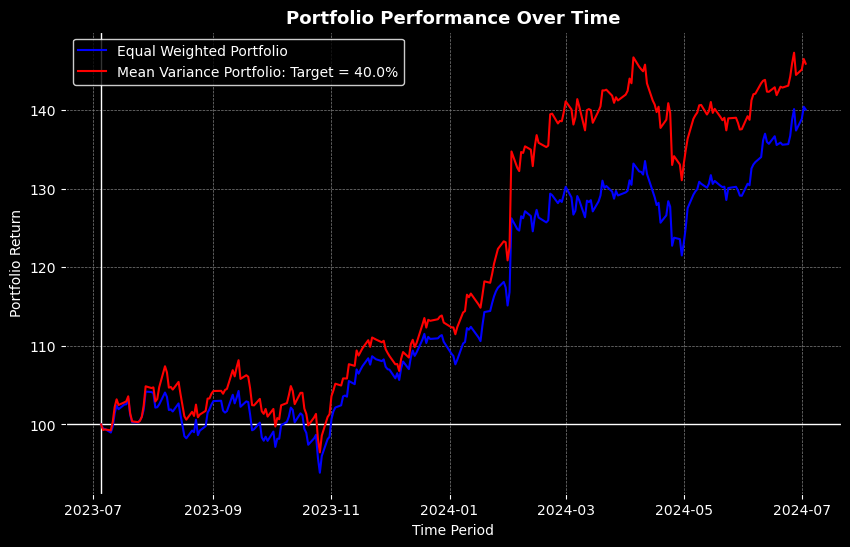

In [11]:
optimal_portfolio = norm_adj_close.dot(optimal_weights)

equal_weights = np.ones(num_assets) / num_assets
equal_weighted_portfolio = norm_adj_close.dot(equal_weights)

# Create a figure with a black background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')
ax.set_facecolor('black')
ax.axhline(100, color='white', linewidth=1)
ax.axvline(equal_weighted_portfolio.index[0], color='white', linewidth=1)
# Plot for equal weighted portfolio and optimal portfolio
ax.plot(equal_weighted_portfolio, label="Equal Weighted Portfolio", color='blue')
ax.plot(optimal_portfolio, label=f"Mean Variance Portfolio: Target = {target_return * 100.}%", color='red')

# Set axis labels and title with white color
ax.set_xlabel('Time Period', color='white')
ax.set_ylabel('Portfolio Return', color='white')
ax.set_title("Portfolio Performance Over Time", fontsize=13, color='white', fontweight='bold')

# Customize grid and ticks
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', colors='white')

# Add a legend
ax.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')

# Display the plot
plt.show()

Random portfolios & Efficient frontier of Markowitz [return - risk]

In [12]:
#List to get the Random Portfolios returns and volatilities
pfolio_returns = []
pfolio_volatilities = []

#Lists to get the Efficient Frontier returns and volatilities
returns_frontier = []
volatility_frontier = []
weights_frontier = []

for x in range (1000):
    # Random weights
    weights = np.random.random(len(tickers))
    # Normalized weights
    weights /= np.sum(weights)
    
    # Portfolio Return
    pfolio_returns.append(calculate_portfolio_return(weights, avg_returns_a))
    # Portfolio Volatility (Standard Deviation)
    pfolio_volatilities.append(calculate_portfolio_volatility(weights, cov_matrix_a))

    target_return = x/25
    optimal_weights = portfolio_optimization(avg_returns_a, cov_matrix_a, target_return, num_assets)
    weights_frontier.append(optimal_weights)
    # Efficient Frontier Return
    returns_frontier.append(calculate_portfolio_return(optimal_weights, avg_returns_a))
    # Efficient Frontier Volatility (Standard Deviation)
    volatility_frontier.append(calculate_portfolio_volatility(optimal_weights, cov_matrix_a))

# Random Portfolio allocation: return and volatility
pfolio_returns = np.array(pfolio_returns)*100
pfolio_volatilities = np.array(pfolio_volatilities)*100
portfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities})

# Efficient Frontier: return and volatility
ef_portfolio = pd.DataFrame({'Return': returns_frontier, 'Volatility': volatility_frontier})
for counter, symbol in enumerate(stock_data.columns.tolist()):
	#print(counter, symbol)
	ef_portfolio[symbol+' weight'] = [w[counter] for w in weights_frontier]

Global minimum variance portfolio

In [13]:
portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]

,Return,Volatility
501,22.770236,11.989041


In [14]:
global_min_var_pf = ef_portfolio[ef_portfolio['Volatility']==ef_portfolio['Volatility'].min()]
global_min_var_pf

,Return,Volatility,Apple weight,Amazon.com weight,Meta_Platforms weight,Berkshire_Hathaway weight
5,0.2,0.111239,0.153623,0.07366,0.0,0.772717


Optimal risky portfolio (highest Sharpe Ratio)

In [17]:
# Get the risk-free rate (10-year US Treasury yield)
risk_free_rate = round((yf.Ticker('^TNX').history()['Close']).iloc[-1]/100 , 4)

print(f"The current risk-free rate (10-year US Treasury yield) is: {risk_free_rate*100:.2f}%")

The current risk-free rate (10-year US Treasury yield) is: 4.33%


In [18]:
Optimal_risky_pf = ef_portfolio.iloc[[((ef_portfolio['Return']-risk_free_rate)/ef_portfolio['Volatility']).idxmax()]]
Optimal_risky_pf

,Return,Volatility,Apple weight,Amazon.com weight,Meta_Platforms weight,Berkshire_Hathaway weight
9,0.36,0.167935,0.0,0.23902,0.261337,0.499643


Capital Market Line

In [19]:
cal_x = []
cal_y = []

for er in np.linspace(risk_free_rate*100, max(ef_portfolio['Return']*100), 20):
	sd = ((er - risk_free_rate*100)*Optimal_risky_pf.iloc[0,1]*100)/(Optimal_risky_pf.iloc[0,0]*100 - risk_free_rate*100)
	cal_x.append(sd)
	cal_y.append(er)

Plot Mean Variance Portfolio

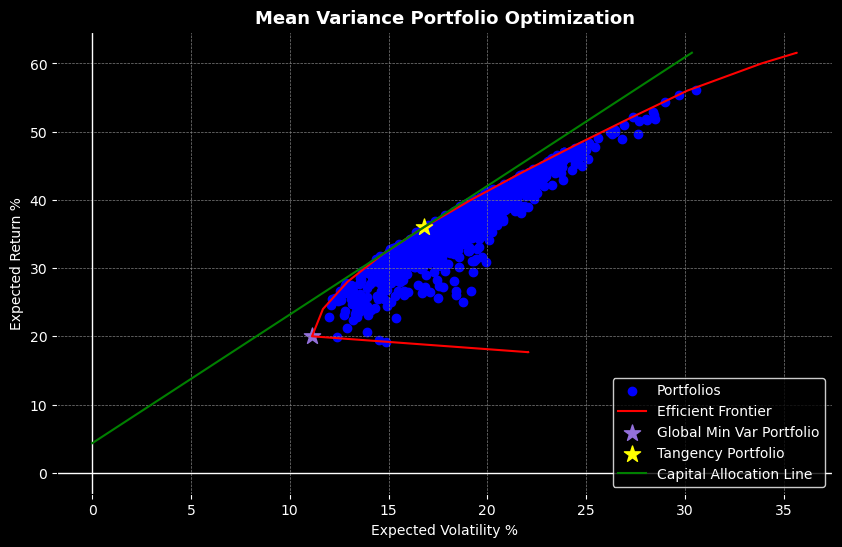

In [20]:
# Create a figure with a black background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')
ax.set_facecolor('black')

ax.axhline(0, color='white', linewidth=1)
ax.axvline(0, color='white', linewidth=1)

# Scatter plot for portfolios
ax.scatter(portfolios.Volatility, portfolios.Return, color='blue', label='Portfolios')

# Set axis labels and title with white color
ax.set_xlabel('Expected Volatility %', color='white')
ax.set_ylabel('Expected Return %', color='white')
ax.set_title("Mean Variance Portfolio Optimization", fontsize=13, color='white', fontweight='bold')

# Plot Efficient Frontier with red color
ax.plot(ef_portfolio.Volatility * 100, ef_portfolio.Return * 100, color="red", label="Efficient Frontier")

# Scatter plots for specific portfolios
ax.scatter(global_min_var_pf.iloc[0,1]*100, global_min_var_pf.iloc[0,0]*100, marker='*', color='#9370DB', s=150, label="Global Min Var Portfolio")
ax.scatter(Optimal_risky_pf.iloc[0,1]*100, Optimal_risky_pf.iloc[0,0]*100, marker='*', color='yellow', s=150, label="Tangency Portfolio")

# Plot Capital Allocation Line with green color
ax.plot(cal_x, cal_y, color='green', label='Capital Allocation Line')

# Customize grid and ticks
ax.grid(color='gray', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', colors='white')

# Add a legend
ax.legend(loc='lower right', facecolor='black', edgecolor='white', labelcolor='white')
fig.savefig('Mean-Variance-PFT.png')
# Display the plot
plt.show()